In [2]:
import pandas as pd
import re
import numpy as np                
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import models
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
#import myfunc as mf # My pre-process functions
import glob

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [4]:
df= pd.read_csv('vf/bert/e_768_last_layer_2024-01-24.csv')
# df= pd.read_csv('saf-data/3072.csv')

In [5]:
df.shape

(342, 769)

In [6]:
# from sklearn import preprocessing
# scaler = preprocessing.MinMaxScaler()
# # scaler = preprocessing.RobustScaler()
# df_X = scaler.fit_transform(df.iloc[:,0:3072].values)
# df_X.shape

In [7]:
df_X = df.iloc[:,0:768].values
# df_X = df[0:768]
# df_X[0]

In [8]:
lbls = df.iloc[:,768].values
# lbls = df[:, 769]
lbls[0]

6

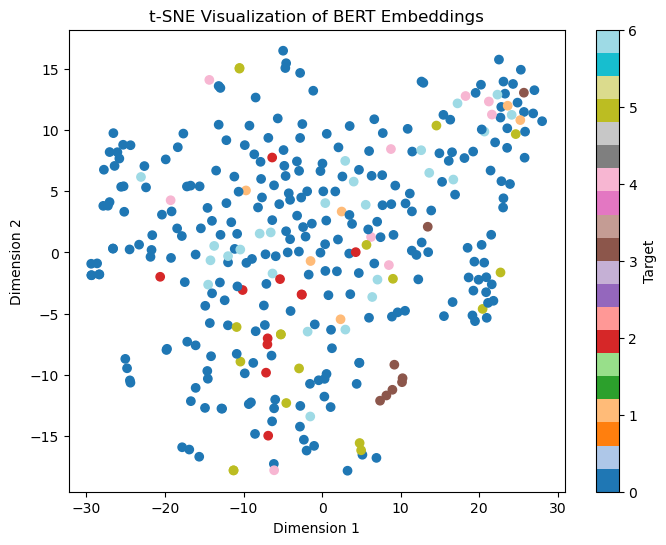

In [9]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=25, n_iter=2000, metric='euclidean', random_state=42) # cosine, 1000, 80
# tsne = TSNE(n_components=2, perplexity=40, n_iter=1000, metric='euclidean')
'''
'minkowski', 'chebyshev', 'manhattan', 'cityblock', 'dice', 'mahalanobis', 'canberra', 'jaccard',
'l2', 'russellrao', 'yule', 'precomputed', 'kulsinski', 'sqeuclidean', 'wminkowski', 'haversine', 
'braycurtis', 'correlation', 'rogerstanimoto', 'matching', 'l1', 
'cosine', 'seuclidean', 'nan_euclidean', 'euclidean', 'sokalmichener', 'hamming', 'sokalsneath'
'''
embeddings_2d = tsne.fit_transform(df_X)


# Plot the t-SNE visualization 2D
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=lbls,  cmap='tab20')
plt.title("t-SNE Visualization of BERT Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar(label='Target')

In [10]:
df_X = embeddings_2d
df_X.shape

(342, 2)

In [11]:
batch_size = 50;
initial_clusters = 2
minimum_threshold_distance = 100
make_new_cluster_threshold = 10 # Atleast 10 deviates

In [12]:
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.cluster import KMeans

# Initialize the K-means model
kmeans = MiniBatchKMeans(n_clusters=initial_clusters, random_state=42,max_iter=2000, n_init=20)
# Fit the initial data to the model
kmeans.fit(df_X[0:batch_size])
h_r=[]
end = batch_size # 30 initially
h_r_less_10 = []
total_dev = [] # now keep track of which how many deviating from which cluster
for i in range(batch_size, len(df_X),batch_size):
    new_vectors = df_X[i:i+batch_size]    # 20:20+20
    predicted_cluster = kmeans.predict(new_vectors)
    print('Predicted clusters')
    print(predicted_cluster)
    print()
    print("kmeans clusters - "+str(kmeans.n_clusters))
    batch_start=i
    batch_end=i+len(new_vectors) # Batch start and end
    batch_ids = np.linspace(batch_start, batch_end,((batch_end-batch_start)+1)) # Batch ids in embeddings
    #print(batch_ids)
    
    ids = {}
    ids_dist = {} # I am using to get each predicted point distance for clusters
    actual_ids = {}
    d = {'nodes':[]}
    start = batch_size # 30
    end = end+len(new_vectors)
    
    print('Start - '+str(start))
    print('End - '+str(end))
    
    for c in range(kmeans.n_clusters):
        ids[c] = np.where(predicted_cluster == c)
        distances = kmeans.transform(df_X[start:end])[:, c] # It tells that the each point is how far from centroid
        ids_dist[c] = distances[ids[c]] # It give distance after assigning or predicted from that centroid
        actual_ids[c] = batch_ids[ids[c]] # Get actual ids of batch
    
#     print('IDS:')
#     print(ids)
#     print()
#     print('Actual IDS:')
#     print(actual_ids)
#     print()
    print('IDS DIST:')
    print(ids_dist)
    

    
    ids_deviating_from_std = {}
    ids_deviating_from_std_actual_keys = {}
    
    
    for key in ids.keys():
        print(f" key is: {key}")
        if (len(ids_dist[key]>0)):
            print(f"length of distances, {len(ids_dist[key])}")

            q1 = np.percentile(ids_dist[key], 42)
            q3 = np.percentile(ids_dist[key], 58)
            iqr = q3 - q1
            lower_bound = q1 - 0.25 * iqr
            upper_bound = q3 + 0.25 * iqr
            print(f"lower bound: {lower_bound}") 
            print("")
            print(f"upper bound: {upper_bound}") 
            print("")
            # Threshold to check distance from mean
            ids_deviating_from_std[key] = (np.where(ids_dist[key] < lower_bound) or np.where(ids_dist[key]>upper_bound))
            ids_deviating_from_std_actual_keys[key] = actual_ids[key][ids_deviating_from_std[key]] # Actual ids of each cluster
            

            print('In each batch how many deviating from Range: '+ str(len(ids_deviating_from_std[key])))
            print('IDS are -- '+str(ids_deviating_from_std[key]))
            print('Deviating from which clusters -- '+str(key))
            print()
            # Second threshold to 
            if len(ids_deviating_from_std_actual_keys[key])>=10:
                print('Parent cluster ----------------------------------------- '+str(key))
                h_r.append((key,kmeans.n_clusters))
                list_deviating = list(map(int, ids_deviating_from_std_actual_keys[key])) # converted list to int
                total_dev.append((key,len(list_deviating)))
#                 print('list deviating')
#                 print(list_deviating)
                vector_for_new_cluster = df_X[list_deviating]
                new_cluster = MiniBatchKMeans(1, random_state=42,max_iter=1000)
                nfit = new_cluster.fit(vector_for_new_cluster)
                kmeans.labels_ = np.append(kmeans.labels_, nfit.labels_ + kmeans.n_clusters)
                kmeans.cluster_centers_ = np.vstack((kmeans.cluster_centers_, nfit.cluster_centers_))
                kmeans.n_clusters += 1
#                 kmeans.partial_fit(vector_for_new_cluster)
            else:
                h_r_less_10.append((key,ids_deviating_from_std_actual_keys[key] ))
        kmeans.partial_fit(new_vectors)
        print('Done')
    
    print(f" total from each cluster : {total_dev}")

Predicted clusters
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 1]

kmeans clusters - 2
Start - 50
End - 100
IDS DIST:
{0: array([16.177197 , 15.526017 , 16.91258  , 15.620279 , 14.233066 ,
        8.103519 ,  8.725959 , 14.4027405, 14.233066 , 16.283787 ,
       17.340694 ,  8.191176 ,  6.1684127, 16.91258  , 16.210987 ,
       15.522057 ,  6.830816 ,  7.172486 , 11.883214 , 16.016504 ,
        5.172272 , 16.179302 ,  6.7669477, 16.511911 ,  9.000529 ,
        6.410992 ,  9.418448 ,  5.9529076, 15.910706 ,  9.3533325,
        9.519703 , 12.646236 , 17.24926  ,  7.8984814, 12.892505 ,
        8.086537 ,  6.810877 , 13.497159 , 13.080212 , 15.910706 ,
        3.7760024,  7.9368243, 14.657599 ], dtype=float32), 1: array([ 9.490749 , 12.190881 , 14.187055 ,  7.516763 , 12.490427 ,
       11.757933 ,  7.1618376], dtype=float32)}
 key is: 0
length of distances, 43
lower bound: 8.295797729492188

upper bound: 15.420519180297852

In each 

Done
 key is: 2
length of distances, 1
lower bound: 21.334453582763672

upper bound: 21.334453582763672

In each batch how many deviating from Range: 1
IDS are -- (array([], dtype=int64),)
Deviating from which clusters -- 2

Done
 key is: 3
length of distances, 10
lower bound: 21.7377517414093

upper bound: 29.001595067977902

In each batch how many deviating from Range: 1
IDS are -- (array([2, 4, 5, 8], dtype=int64),)
Deviating from which clusters -- 3

Done
 key is: 4
length of distances, 5
lower bound: 44.36071304321289

upper bound: 46.09702163696289

In each batch how many deviating from Range: 1
IDS are -- (array([0, 2], dtype=int64),)
Deviating from which clusters -- 4

Done
 key is: 5
length of distances, 2
lower bound: 13.708543868064881

upper bound: 19.411534695625306

In each batch how many deviating from Range: 1
IDS are -- (array([1], dtype=int64),)
Deviating from which clusters -- 5

Done
 key is: 6
length of distances, 2
lower bound: 18.327306518554686

upper bound: 19.

In [13]:
kmeans.n_clusters

9

In [14]:
h_r_less_10

[(1, array([53., 83., 99.])),
 (2, array([106., 117., 121., 130.])),
 (0, array([188., 190., 191., 196.])),
 (1, array([163., 168., 173., 185.])),
 (2, array([162., 175., 189., 197.])),
 (4, array([167., 179.])),
 (0, array([223., 246.])),
 (1, array([218., 235., 247.])),
 (2, array([], dtype=float64)),
 (3, array([203., 228., 236., 244.])),
 (4, array([219., 220.])),
 (0, array([267., 291.])),
 (2, array([], dtype=float64)),
 (3, array([283., 285., 288., 296.])),
 (4, array([269., 273.])),
 (5, array([294.])),
 (6, array([280.])),
 (0, array([313., 338.])),
 (1, array([323.])),
 (2, array([340.])),
 (4, array([317., 320.])),
 (5, array([301., 327.])),
 (6, array([], dtype=float64))]

In [15]:
h_r

[(0, 2), (0, 3), (1, 4), (3, 5), (5, 6), (1, 7), (3, 8)]

In [16]:
total_dev

[(0, 14), (0, 7), (1, 9), (3, 6), (5, 5), (1, 8), (3, 7)]

In [17]:
centroids = kmeans.cluster_centers_
# centroids

In [ ]:
#done